# Model Evaluation

### Objective:
The objective of this notebook is to evaluate the optimized LightGBM model's performance, identify any signs of overfitting, and assess its ability to generalize across different datasets using cross-validation techniques.

### Summary:
Initial cross-validation results indicated significant variability in the model's error metrics, especially in higher price ranges. This raised concerns about overfitting due to the uneven distribution of target variables across the folds. To address this, stratified KFold cross-validation was applied, which ensured a more balanced distribution of price ranges across the folds. This adjustment led to more consistent model performance and reduced error variability.

#### **Key Findings**:
#### Stratified Cross-Validation Performance:
- **Mean Absolute Error (MAE)**:
  - Average MAE Scores: `$1,662.70`, the model was more consistent across folds, resulting in an improved average mae.

<br>
  
- **Mean Squared Error (MSE)**:
  - Average MSE Scores: `6,506,722`, although the MSE showed some variability, the mse had an improved average mse.

<br>

- **R² Score**:
  - Average R² Scores: `0.9625`, indicating that the model consistently captures a significant portion of the variance in the target variable across all folds.

In [ ]:
# Necessary libraries
import pandas as pd
import numpy as np
import joblib 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate, train_test_split
import lightgbm

### Process Data and Load Model

In [ ]:
# Load data
df_cars = pd.read_csv('cleaned_data_july_21st.csv')  

# Load final model and final scaler
final_model = joblib.load('final_model.pkl')
final_scaler = joblib.load('final_scaler.pkl')

# Define features and target
features = ['Year', 'Model', 'State', 'Mileage', 'Trim', 'Make', 'Body Style']
X = df_cars[features].copy()
y = df_cars['Price']

# Define and format categorical features
categorical_features = ['Model', 'State', 'Trim', 'Make', 'Body Style']
X[categorical_features] = X[categorical_features].astype('category')

# Scale numerical features
X[['Year', 'Mileage']] = final_scaler.fit_transform(X[['Year', 'Mileage']])

print('Data & final model loaded')
print('\nTrain/Test Data Row & Column Count:', X.shape)

Data & final model loaded

Train/Test Data Row & Column Count: (82895, 7)


## Cross-Validation

In [ ]:
# Run cross-validation
cv_scores = cross_val_score(final_model, X, y, cv=10, scoring='neg_mean_absolute_error')

# Print cross-validation MAE performance
print('\033[1mCross-Validation MAE Performance:\033[0m')
print('MAE Scores for each Fold:', [-round(score, 2) for score in cv_scores])
print('\033[1mAverage MAE Score:\033[0m $', round(-cv_scores.mean(), 2))

# Print orignal data performance
print('\n\033[1mFinal Model (LightGBM) Performance:\033[0m')
print('Mean Absolute Error (MAE): $ 1,609.03')
print('Mean Squared Error  (MSE): 7,441,905')
print('R² Score             (R²): 0.9573')

Cross-Validation MAE Performance:
MAE Scores for each Fold: [6238.19, 5051.32, 3047.97, 2903.06, 5144.06, 3706.48, 2315.93, 2928.0, 2292.14, 7014.69]
Average MAE Score: $ 4064.18

Final Model (LightGBM) Performance:
Mean Absolute Error (MAE): $ 1,609.03
Mean Squared Error  (MSE): 7,441,905
R² Score             (R²): 0.9573


### Examine Train/Test for Imbalance


Counts in Each Bin (Training Set vs Test Set):
               Training Set Counts  Test Set Counts
Price Range                                        
0-10000                       3315              831
10000-20000                  19269             4824
20000-30000                  23939             6032
30000-40000                  11908             2887
40000-50000                   4233             1108
50000-60000                   1768              421
60000-70000                   1037              269
70000-80000                    548              133
80000-90000                    215               54
90000-100000                    62               12
100000-110000                    6                1
110000-120000                    4                1
120000-130000                    5                5
130000-140000                    3                0
140000-150000                    4                1

Percentages in Each Bin (Training Set vs Test Set):
               

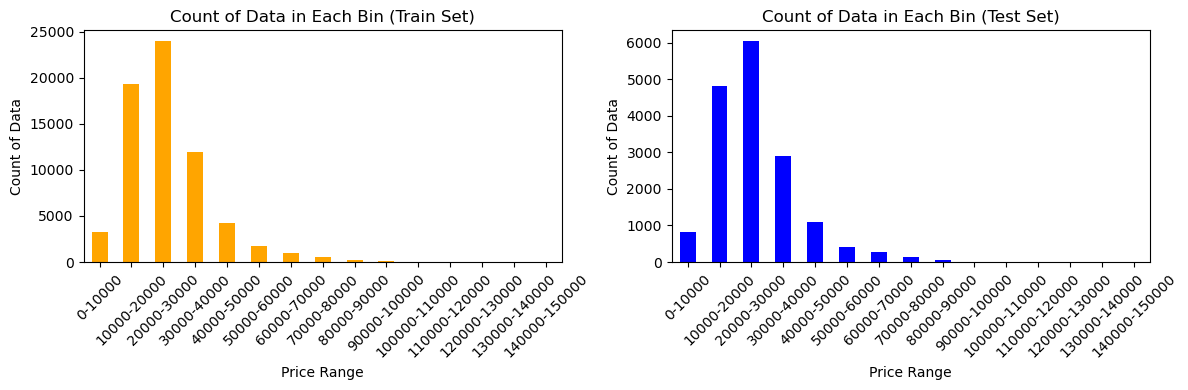

In [ ]:
# Define price bins
price_bins_10k = np.arange(0, 160000, 10000)
labels = [f'{int(bin)}-{int(bin+10000)}' for bin in price_bins[:-1]]

# Create dataframe for train/test price column
price_train = pd.DataFrame({'Price': y_train})
price_test = pd.DataFrame({'Price': y_test})

# Define price bines
price_train['Price Range'] = pd.cut(price_train['Price'], bins=price_bins_10k, labels=labels, include_lowest=True)
price_test['Price Range'] = pd.cut(price_test['Price'], bins=price_bins_10k, labels=labels, include_lowest=True)

# Counts for each bin
train_counts = price_train['Price Range'].value_counts().sort_index()
test_counts = price_test['Price Range'].value_counts().sort_index()

# Percentages for each bin
train_percentage = (train_counts / train_counts.sum()) * 100
test_percentage = (test_counts / test_counts.sum()) * 100


# Dataframe to display counts
price_counts = pd.DataFrame({
    'Training Set Counts': train_counts,
    'Test Set Counts': test_counts
})

# Dataframe for percentages
price_percentages = pd.DataFrame({
    'Training Set %': train_percentage.round(2),
    'Test Set %': test_percentage.round(2)
})

# Print counts and percentages
print("\nCounts in Each Bin (Training Set vs Test Set):")
print(counts_df)

print("\nPercentages in Each Bin (Training Set vs Test Set):")
print(percentages_df)

# Plot train & test counts
plt.figure(figsize=(12, 4))

# Plot counts for the training set
plt.subplot(1, 2, 1)
train_bin_counts_absolute.plot(kind='bar', color='orange')
plt.title('Count of Data in Each Bin (Train Set)')
plt.xlabel('Price Range')
plt.ylabel('Count of Data')
plt.xticks(rotation=45)

# Plot absolute counts for the test set
plt.subplot(1, 2, 2)
test_bin_counts_absolute.plot(kind='bar', color='blue')
plt.title('Count of Data in Each Bin (Test Set)')
plt.xlabel('Price Range')
plt.ylabel('Count of Data')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

#### Initial Cross-Validation Analysis:
- The initial cross-validation MAE of `3,261.53` was significantly higher than the original MAE of `$1,680`, which indicated poor generalization due to an imbalance in the target variable distribution.
- Analysis of the target distribution showed that more than `88%` of the target values fall below `$40,000`, when grouped into increments of `$10,000`. 
- To address this, stratified KFold cross-validation was implemented by binning the target variable into price increments of `$5,000` up to `$50,000`, and then larger bins for higher price ranges, ensuring better data balance across folds.

## Stratified Cross-Validation

In [ ]:
# Define bins and labels for stratified CV
price_bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 75000, np.inf]
bin_labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-30k', 
              '30k-35k', '35k-40k', '40k-45k', '45k-50k', '50k-75k', '75k+']
y_binned = pd.cut(y.values, bins=price_bins, labels=bin_labels, include_lowest=True)

# Print counts of each bin
print('Bin distribution count:')
print(y_binned.value_counts(),'\n')

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Define scoring metrics
scoring = scoring = {'MAE': 'neg_mean_absolute_error', 
                     'MSE': 'neg_mean_squared_error', 
                     'R²': 'r2'
                    }

# Cross-validation
scores = cross_validate(final_model, X, y.to_numpy(), cv=skf.split(X, y_binned), scoring=scoring)
                                                                     # `cv=skf.split(X, y_binned)` to ensure stratification by the binned variable

# Print performance
print('\n\033[1mFinal Model Stratified Cross-Validation Performance:\033[0m')

# MAE, MSE, R² performance for each fold
print('Stratified MAE Scores:', [-round(score, 2) for score in scores['test_MAE']])
print('Stratified MSE Scores:', [-int(round(score)) for score in scores['test_MSE']])
print('Stratified R² Scores:', [round(score, 4) for score in scores['test_R2']])

# Average MAE, MSE, R² performance across all folds
print('\n\033[1mAverage Stratified Cross-Validation Performance:\033[0m')
print(f'Avgerage Mean Absolute Error (MAE): $ {-scores["test_MAE"].mean():,.2f}')
print(f'Avgerage Mean Squared Error  (MSE): {int(-scores["test_MSE"].mean()):,}')
print(f'Avgerage R² Score             (R²): {scores["test_R2"].mean():.4f}')

# Print orignal model performance
print('\n\033[1mFinal Model (LightGBM) Performance:\033[0m')
print('Mean Absolute Error (MAE): $ 1,609.03')
print('Mean Squared Error  (MSE): 7,441,905')
print('R² Score             (R²): 0.9573')

Bin distribution count:
0-5k         215
5k-10k      3931
10k-15k     9039
15k-20k    15054
20k-25k    16178
25k-30k    13793
30k-35k     8846
35k-40k     5949
40k-45k     3175
45k-50k     2166
50k-75k     3863
75k+         686
Name: count, dtype: int64 


Final Model Stratified Cross-Validation Performance:
Stratified MAE Scores: [1672.7, 1645.65, 1631.5, 1638.5, 1627.8, 1634.33, 1646.73, 1613.22, 1624.55, 1601.66]
Stratified MSE Scores: [8205148, 6820658, 6546990, 7111788, 6785025, 6637460, 6462324, 6537730, 7310254, 6464419]
Stratified R² Scores: [0.9537, 0.9613, 0.9618, 0.9588, 0.9606, 0.9619, 0.9631, 0.9616, 0.9581, 0.9626]

Average Stratified Cross-Validation Performance:
Avgerage Mean Absolute Error (MAE): $ 1,633.66
Avgerage Mean Squared Error  (MSE): 6,888,179
Avgerage R² Score             (R²): 0.9603

Final Model (LightGBM) Performance:
Mean Absolute Error (MAE): $ 1,609.03
Mean Squared Error  (MSE): 7,441,905
R² Score             (R²): 0.9573


## **Conclusion - Cross-Validation**:
Applying stratified cross-validation significantly improved the model’s generalization capabilities, reducing the variability in MAE and MSE across different data folds. This adjustment mitigated the overfitting concerns observed in the initial cross-validation and produced a more robust evaluation of the model’s performance.

## Plotting Model Performance

### Residuals (Prediction Errors)

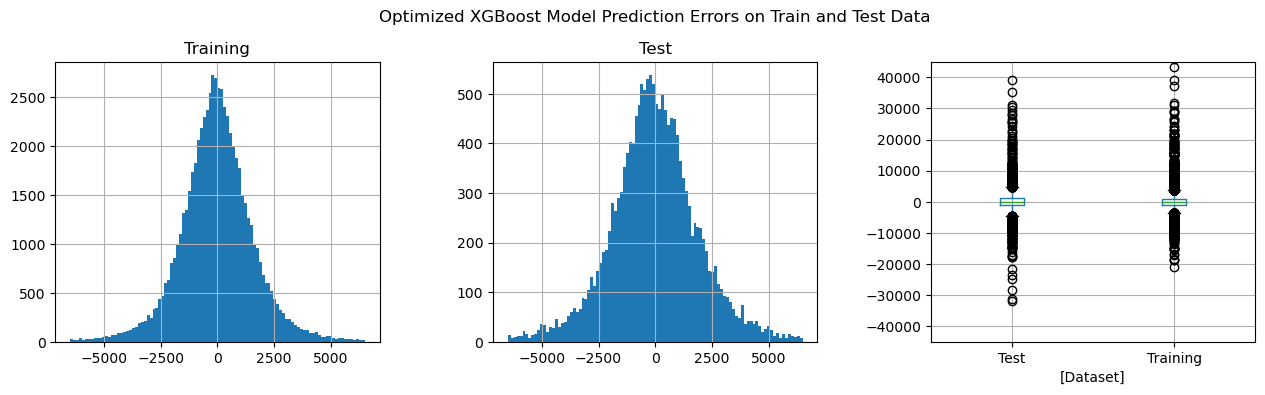

In [ ]:
# Split data, 80/20 train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=1)

# Predictions for training and test data
train_pred = final_model.predict(X_train).flatten()
test_pred = final_model.predict(X_test).flatten()

# Calculate residuals 
pred_error_train = pd.DataFrame({'Residual': y_train.to_numpy() - train_pred, 
                                 'Dataset': 'Training'})
pred_error_test = pd.DataFrame({'Residual': y_test.to_numpy() - test_pred, 
                                'Dataset': 'Test'})
boxplot = pd.concat([pred_error_train, pred_error_test], ignore_index=True)

# Configure plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
parameters = {'bins': 100, 'range': [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **parameters)
pred_error_test.hist(ax=axes[1], **parameters)
boxplot.boxplot(ax=axes[2], by='Dataset')

# Plot titles and layout
axes[0].set_title('Training')
axes[1].set_title('Test')
axes[2].set_title('')
axes[2].set_ylim(-45000, 45000)
plt.suptitle(f'Optimized XGBoost Model Prediction Errors on Train and Test Data') 
plt.subplots_adjust(bottom=0.15, top=0.85, wspace=0.35)
plt.show()

### MAE by Price Bin

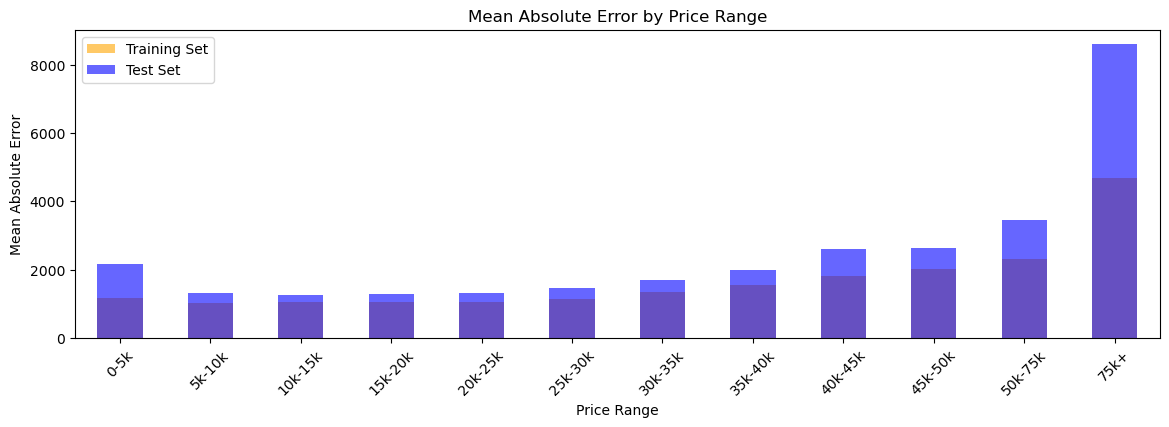


Training Set Avg MAE in each bin:
0-5k               1156.93
5k-10k             1019.75
10k-15k            1038.48
15k-20k            1048.62
20k-25k            1061.04
25k-30k            1149.03
30k-35k            1340.27
35k-40k            1557.87
40k-45k            1817.68
45k-50k            2018.78
50k-75k            2324.66
75k+               4696.32

Training Set Avg MAE in each bin:
0-5k               2163.96
5k-10k             1324.76
10k-15k            1262.52
15k-20k            1287.23
20k-25k            1302.24
25k-30k            1474.63
30k-35k            1699.05
35k-40k            1981.33
40k-45k            2614.42
45k-50k            2641.70
50k-75k            3455.41
75k+               8606.24


In [ ]:
# Calculate MAE for both sets
mae_train = np.abs(y_train - train_pred)
mae_test = np.abs(y_test - test_pred)

# Create DataFrames for training and test sets
price_train = pd.DataFrame({'Price': y_train, 'MAE': mae_train})
price_test = pd.DataFrame({'Price': y_test, 'MAE': mae_test})

# Define price bines
price_train['Price Range'] = pd.cut(price_train['Price'], bins=price_bins, labels=bin_labels, include_lowest=True)
price_test['Price Range'] = pd.cut(price_test['Price'], bins=price_bins, labels=bin_labels, include_lowest=True)

# Calculate mean errors for each price range
mean_errors_train = price_train.groupby('Price Range', observed=False)['MAE'].mean()
mean_errors_test = price_test.groupby('Price Range', observed=False)['MAE'].mean()

# Configure plot
plt.figure(figsize=(14, 4))
mean_errors_train.plot(kind='bar', color='orange', alpha=0.6, label='Training Set')
mean_errors_test.plot(kind='bar', color='blue', alpha=0.6, label='Test Set')

# Plot titles and layout
plt.xlabel('Price Range')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Price Range')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Print the average MAE for each price bin in each set
print("\nTraining Set Avg MAE in each bin:")
for label, mae in mean_errors_train.items():
    print(f"{label:<15} {mae:>10.2f}")

print("\nTraining Set Avg MAE in each bin:")
for label, mae in mean_errors_test.items():
    print(f"{label:<15} {mae:>10.2f}")

## **Conclusion - Model Evaluation**:
Overall, the LightGBM model demonstrated robust predictive accuracy, with a final MAE of `$1,609.03` and an R² score of `0.9573` on the original dataset. Stratified cross-validation provided a clearer view of the model’s generalization, ensuring reliable predictions across different data subsets. 